In [3]:
 %cd /sci/labs/yotamd/lab_share/avishai.wizel/eRNA/

/sci/labs/yotamd/lab_share/avishai.wizel/eRNA


/sci/labs/yotamd/lab_share/avishai.wizel/python_envs/miniconda/envs/tf_gpu_env/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
from scipy.sparse import issparse
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import regularizers
from tensorflow import keras
import tensorflow_addons as tfa



# Load data

In [5]:
sc_rna = ad.read_h5ad('./10X_PBMC/03_filtered_data/filtered_rna_adata.h5ad')
sc_atac = ad.read_h5ad("./10X_PBMC/03_filtered_data/filtered_atac_adata.h5ad")

/sci/labs/yotamd/lab_share/avishai.wizel/python_envs/miniconda/envs/tf_gpu_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# Main parameters

In [6]:
top_rna_var_genes = 5000
top_var_peaks = 500

# Filters cells

In [7]:
def filter_cells_by_qc_metrics(
    adata: ad.AnnData,
    min_genes: int = 200,
    max_genes: int = 2500,
    min_counts: int = 1000,
    max_mt_pct: float = 40.0
) -> ad.AnnData:
    """
    Filters cells based on standard quality control metrics:
    number of genes detected, total counts, and mitochondrial gene percentage.

    Args:
        adata (anndata.AnnData):
            The AnnData object containing raw gene expression counts (cells x genes).
            Assumes mitochondrial genes are prefixed with 'MT-' (human) or 'mt-' (mouse).
        min_genes (int): Minimum number of genes expressed per cell.
        max_genes (int): Maximum number of genes expressed per cell (to remove doublets).
        min_counts (int): Minimum total counts per cell.
        max_mt_pct (float): Maximum allowed percentage of mitochondrial counts per cell.

    Returns:
        anndata.AnnData: A new AnnData object with filtered cells.
                         QC metrics are added to adata.obs.
    """
    
    # Ensure adata.var['mt'] is set if not already
    if 'mt' not in adata.var:
        # Assuming human data with 'MT-' prefix. Adjust for mouse ('mt-') or other.
        adata.var['mt'] = adata.var_names.str.startswith('MT-') 

    print("Calculating QC metrics...")
    sc.pp.calculate_qc_metrics(
        adata, 
        qc_vars=['mt'], 
        percent_top=None, 
        log1p=False, 
        inplace=True
    )

    print(f"Original number of cells: {adata.n_obs}")
    
    # Apply filters
    initial_cells_count = adata.n_obs
    
    # Combine filtering criteria using boolean logic
    cells_to_keep = (
        (adata.obs['n_genes_by_counts'] >= min_genes) &
        (adata.obs['n_genes_by_counts'] <= max_genes) &
        (adata.obs['total_counts'] >= min_counts) &
        (adata.obs['pct_counts_mt'] <= max_mt_pct)
    )
    
    adata_filtered = adata[cells_to_keep, :].copy()
    
    filtered_cells_count = adata_filtered.n_obs
    removed_cells_count = initial_cells_count - filtered_cells_count
    
    print(f"Cells removed: {removed_cells_count}")
    print(f"Number of cells after filtering: {filtered_cells_count}")

    return adata_filtered

In [8]:
adata_filtered_qc = filter_cells_by_qc_metrics(
    sc_rna.copy(),
    min_genes=200,
    max_genes=2500,
    min_counts=500,
    max_mt_pct=25
)

/sci/labs/yotamd/lab_share/avishai.wizel/python_envs/miniconda/envs/tf_gpu_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Calculating QC metrics...
Original number of cells: 11852
Cells removed: 2502
Number of cells after filtering: 9350


/sci/labs/yotamd/lab_share/avishai.wizel/python_envs/miniconda/envs/tf_gpu_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# Normalize scRNA-seq

In [9]:
# 1. Size Normalization
sc.pp.normalize_total(adata_filtered_qc, target_sum=1e4)

# 2. Log-transformation (log1p)
sc.pp.log1p(adata_filtered_qc)
sc.pp.highly_variable_genes(adata_filtered_qc, n_top_genes=top_rna_var_genes, flavor='seurat')


Take only high variable genes:

In [10]:
sc_rna_filtered = adata_filtered_qc[:, adata_filtered_qc.var.highly_variable].copy()

# filter atac cells based on filtered rna cells
filtered_cell_barcodes = sc_rna_filtered.obs_names
adata_atac_filtered = sc_atac[sc_atac.obs_names.isin(filtered_cell_barcodes), :].copy()
adata_atac_filtered = sc_atac[filtered_cell_barcodes, :].copy()



# Filter for highly variable peaks

In [11]:
def get_top_n_highly_variable_peaks(adata_atac: ad.AnnData, n_top_peaks: int = 10000) -> ad.AnnData:
    """
    Identifies and keeps the top N highly variable peaks in an AnnData object
    based on their variance-to-mean ratio (a proxy for dispersion).

    Args:
        adata_atac (anndata.AnnData):
            The AnnData object containing ATAC-seq data (cells x peaks).
            Assumes adata_atac.X contains counts or binarized values.
        n_top_peaks (int):
            The number of top highly variable peaks to select.

    Returns:
        anndata.AnnData: An AnnData object subsetted to include only the selected top N peaks.
                         Statistical information is added to adata_atac.var.
    """
    
    print(f"Original AnnData shape (cells x peaks): {adata_atac.shape}")

    # Convert to dense for calculation if sparse, using float32 for memory efficiency
    data = adata_atac.X.toarray().astype(np.float32) if issparse(adata_atac.X) else adata_atac.X.astype(np.float32)
    
    # Calculate mean and variance for each peak (column-wise)
    peak_means = np.mean(data, axis=0)
    peak_variances = np.var(data, axis=0)
    
    # Avoid division by zero for peaks with zero mean
    # A common approach is to add a small constant to the mean or handle NaN results.
    # For ATAC (binary), peaks with zero mean have zero variance and are not variable.
    # We'll set dispersion to 0 for these or filter them out.
    
    # Calculate variance-to-mean ratio as a measure of dispersion
    # Adding a small epsilon to avoid division by zero
    epsilon = 1e-6 
    dispersion = peak_variances / (peak_means + epsilon)
    
    # Store these metrics in adata.var
    adata_atac.var['peak_means'] = peak_means
    adata_atac.var['peak_variances'] = peak_variances
    adata_atac.var['peak_dispersion'] = dispersion

    # Rank peaks by dispersion and select top N
    # Sort in descending order
    adata_atac.var['ranked_dispersion'] = adata_atac.var['peak_dispersion'].rank(ascending=False, method='first')
    
    selected_peaks = adata_atac.var[adata_atac.var['ranked_dispersion'] <= n_top_peaks].index
    
    adata_filtered_peaks = adata_atac[:, selected_peaks].copy()
    
    print(f"AnnData shape after filtering to top {n_top_peaks} highly variable peaks: {adata_filtered_peaks.shape}")
    
    return adata_filtered_peaks


In [12]:
adata_hvps = get_top_n_highly_variable_peaks(adata_atac_filtered.copy(), top_var_peaks)


Original AnnData shape (cells x peaks): (9350, 67207)
AnnData shape after filtering to top 500 highly variable peaks: (9350, 500)


In [13]:
scRNA = sc_rna_filtered.X
scATAC_binary = adata_hvps.X.toarray()
del(sc_rna)
del(sc_atac)
del(adata_atac_filtered)
del(sc_rna_filtered)

In [14]:
print("scRNA dim (cells X genes):" ,scRNA.shape)
print("scATAC dim (cells X peaks):" ,scATAC_binary.shape)

scRNA dim (cells X genes): (9350, 5000)
scATAC dim (cells X peaks): (9350, 500)


In [15]:
# Standardize the RNA-seq data
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(scRNA.toarray())

In [16]:
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(scATAC_binary)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [18]:
# # Calculate the total number of zeros and ones across all peaks combined
# # This flattens the array and then counts occurrences of 0s and 1s.
# num_zeros = np.sum(y_train == 0)
# num_ones = np.sum(y_train == 1)
# total_elements = num_zeros + num_ones # Total number of 0s and 1s combined in y_train

# # Calculate class weights
# # These weights are inversely proportional to the class frequencies.
# # This assigns a higher weight to the less frequent class (typically '1's in imbalanced data)
# # to make the model pay more attention to correctly classifying them.
# # The 'total_elements / 2.0' part ensures the sum of weights for a balanced dataset
# # would ideally be around 1, helping to stabilize the loss scale.

# # Ensure no division by zero if a class is completely absent (though rare for 0/1)
# weight_for_0 = (total_elements / (10.0 * num_zeros)) if num_zeros > 0 else 1.0
# weight_for_1 = (total_elements / (2.0 * num_ones)) if num_ones > 0 else 1.0

# # Store the calculated weights in a dictionary format required by Keras
# class_weights = {0: weight_for_0, 1: weight_for_1}
# print(f"Computed class weights: {class_weights}")


In [19]:

# --- 2. Building the Keras Neural Network Model ---

# Define model parameters
input_dim = X_train.shape[1]  # Number of genes (input features)
output_dim = y_train.shape[1] # Number of ATAC genomic locations (output targets)

# Build the Sequential Keras model
model = keras.Sequential([
    # Input Layer: Defines the shape of the input data
    layers.Input(shape=(input_dim,)),

    # Hidden Layers (Dense - Fully Connected)
    # Common to start with larger layers and gradually decrease units.
    # 'relu' (Rectified Linear Unit) is a common activation function for hidden layers.
    layers.Dense(units=512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2), # Dropout layer for regularization (prevents overfitting), dropping 20% of neurons
    layers.Dense(units=256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=128, activation='relu'),
    layers.BatchNormalization(),
    # You can add more layers here if needed

    # Output Layer
    # The number of units must match the number of ATAC locations (output_dim).
    # Activation function:
    # - 'linear' (or no activation) for continuous regression output (e.g., after StandardScaler).
    # - 'sigmoid' if your 'y' targets are scaled between 0 and 1 (e.g., after MinMaxScaler)
    #   or if they are binary (0/1) representing probabilities.
     layers.Dense(units=output_dim, activation='sigmoid')
])

# Compile the model
# Optimizer: 'adam' is a popular and efficient optimizer.
# Loss function:
# - 'mse' (Mean Squared Error) is standard for regression problems.
# - 'mae' (Mean Absolute Error) is another common choice for regression.
# - If your output is binary (0/1) with 'sigmoid' activation, use 'binary_crossentropy' for loss.
optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9) # Start with 0.01 for LR

# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae', 'accuracy']) # Using MAE as an additional metric

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Can lower to 1e-4 if data is noisy
    loss=tfa.losses.SigmoidFocalCrossEntropy(
        gamma=2.0,      # Focus more on hard examples
        alpha=0.25      # Down-weight the majority class (0s)
    ),
    metrics=[
        tf.keras.metrics.AUC(
            curve='PR',         # Precision-Recall AUC
            multi_label=True,   # Required for multi-label output
            num_labels=output_dim,  # Set to your output vector size
            name='pr_auc'
        ),
        tf.keras.metrics.BinaryAccuracy(name='bin_acc'),   # Overall binary accuracy
        tf.keras.metrics.Precision(name='precision'),      # How many predicted positives were correct
        tf.keras.metrics.Recall(name='recall')             # How many actual positives were found
    ]
)

# Print a summary of the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               2560512   
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

2025-07-23 14:42:19.830201: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [21]:

# --- 3. Training the Model ---

print("\nStarting model training...")
history = model.fit(
    X_train, y_train,
    epochs=50,          # Number of times to iterate over the entire training dataset
    batch_size=32,      # Number of samples per gradient update
    validation_split=0.1, # Fraction of the training data to be used as validation data
                          # This helps monitor performance on unseen data during training.
    verbose=1,           # Display progress bar during training
    # class_weight=class_weights
)
print("Model training complete.")





Starting model training...
Epoch 1/50
211/211 [==============================] - 5s 16ms/step - loss: 29.0064 - pr_auc: 0.0058 - bin_acc: 0.8866 - precision: 0.0052 - recall: 0.1179 - val_loss: 2.3687 - val_pr_auc: 0.0274 - val_bin_acc: 0.9952 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
211/211 [==============================] - 3s 14ms/step - loss: 1.5885 - pr_auc: 0.0211 - bin_acc: 0.9952 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3824 - val_pr_auc: 0.0377 - val_bin_acc: 0.9952 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
211/211 [==============================] - 3s 14ms/step - loss: 1.3424 - pr_auc: 0.0301 - bin_acc: 0.9952 - precision: 0.1000 - recall: 1.2270e-04 - val_loss: 1.3194 - val_pr_auc: 0.0389 - val_bin_acc: 0.9952 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
211/211 [==============================] - 3s 14ms/step - loss: 1.2944 - pr_auc: 0.0342 - bin_acc: 0.9952 - precision: 0.5000 - recall: 6.135

KeyError: 'mae'

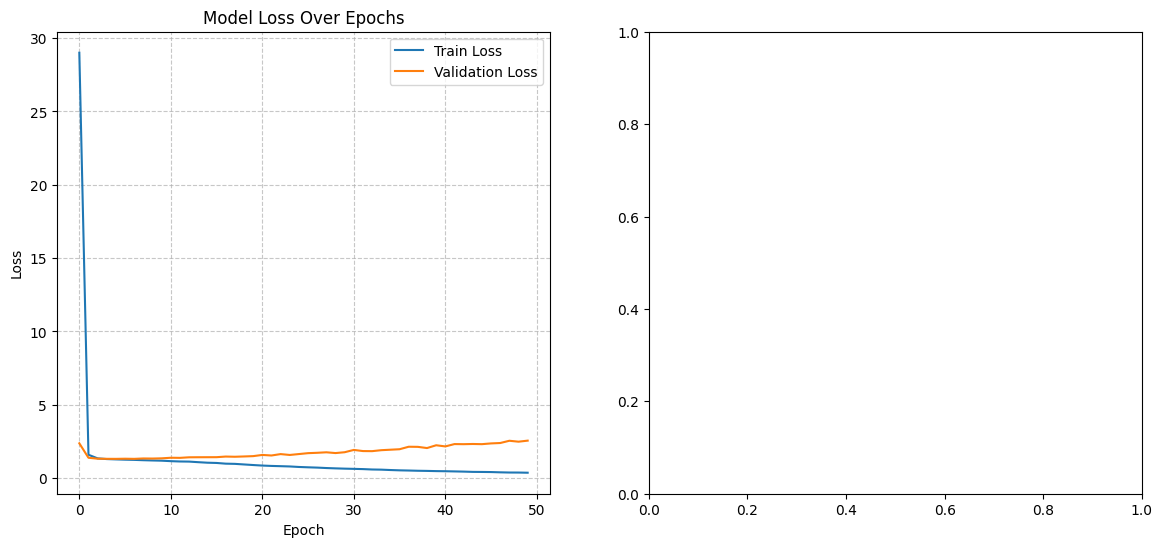

In [22]:
# Plotting training history (loss and metrics)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [23]:
# Assuming X_test_for_nn and y_test_scaled are your prepared test data

print("Evaluating model on the test set...")
test_loss, test_mae, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Evaluating model on the test set...
59/59 [==============================] - 0s 5ms/step - loss: 2.4929 - pr_auc: 0.0311 - bin_acc: 0.9949 - precision: 0.1376 - recall: 0.0056


ValueError: too many values to unpack (expected 3)

In [24]:
# --- 2. Make predictions on X_test ---
print("Making predictions on X_test...")
y_pred_probabilities = model.predict(X_test) # Get probabilities (values between 0 and 1)

# --- 3. Convert probabilities to binary predictions ---
# We use a threshold (e.g., 0.5) to convert the probabilities to 0s or 1s.
# Adjust this threshold if you've found a better one during validation.
prediction_threshold = 0.05
y_pred_binary = (y_pred_probabilities > prediction_threshold).astype(int)

print(f"Predictions generated with threshold: {prediction_threshold}")

Making predictions on X_test...
59/59 [==============================] - 0s 2ms/step
Predictions generated with threshold: 0.05


In [25]:
# Flatten arrays to easily count global statistics across all peaks
# y_test_scaled should already be 0s and 1s
y_test_flat = y_test.flatten()
y_pred_flat = y_pred_binary.flatten()

# --- 1. Count predicted 0s and 1s ---
predicted_ones_count = np.sum(y_pred_flat == 1)
predicted_zeros_count = np.sum(y_pred_flat == 0)

print(f"\nTotal predicted 1s: {predicted_ones_count}")
print(f"Total predicted 0s: {predicted_zeros_count}")

true_ones_count = np.sum(y_test_flat == 1)
true_zeros_count = np.sum(y_test_flat == 0)
print(f"\nTotal true 1s: {true_ones_count}")
print(f"Total true 0s: {true_zeros_count}")


# --- 2. Count True Positives (TP) ---
# True Positives are instances where the true label is 1 AND the prediction is 1.
# This corresponds to "כמה מה-1 שהיו ב-y_test הם גם אחד בחיזוי"
true_positives = np.sum((y_test_flat == 1) & (y_pred_flat == 1))

print(f"\nNumber of 1s in y_test that were also predicted as 1 (True Positives): {true_positives}")


# --- 3. Count predicted 1s that are actually 1 ---
# This is the same as True Positives, phrased differently,
# or if you meant something related to precision.
# The question "כמה מה-1 שבחיזוי הם גם ב-y_test" is precisely True Positives.
# Let's also calculate the total actual 1s in y_test for context.
total_actual_ones_in_y_test = np.sum(y_test_flat == 1)

print(f"Total actual 1s in y_test: {total_actual_ones_in_y_test}")
print(f"Number of 1s predicted that are also 1 in y_test (True Positives): {true_positives}")


# For additional context, you might be interested in Precision for class 1:
# Precision = True Positives / (True Positives + False Positives)
# If predicted_ones_count is 0, precision is undefined or set to 0.
if predicted_ones_count > 0:
    precision_of_ones = true_positives / predicted_ones_count
    print(f"Precision for predicted 1s: {precision_of_ones:.4f}")
else:
    print("No 1s were predicted, Precision for 1s is undefined.")

# And Recall for class 1:
# Recall = True Positives / (True Positives + False Negatives) = True Positives / Total Actual 1s
if total_actual_ones_in_y_test > 0:
    recall_of_ones = true_positives / total_actual_ones_in_y_test
    print(f"Recall for actual 1s: {recall_of_ones:.4f}")
else:
    print("No actual 1s in y_test to calculate Recall.")


Total predicted 1s: 66025
Total predicted 0s: 868975

Total true 1s: 4607
Total true 0s: 930393

Number of 1s in y_test that were also predicted as 1 (True Positives): 1070
Total actual 1s in y_test: 4607
Number of 1s predicted that are also 1 in y_test (True Positives): 1070
Precision for predicted 1s: 0.0162
Recall for actual 1s: 0.2323


Making predictions on X_test to get probabilities...
59/59 [==============================] - 0s 2ms/step

Micro-averaged PR AUC: 0.0156


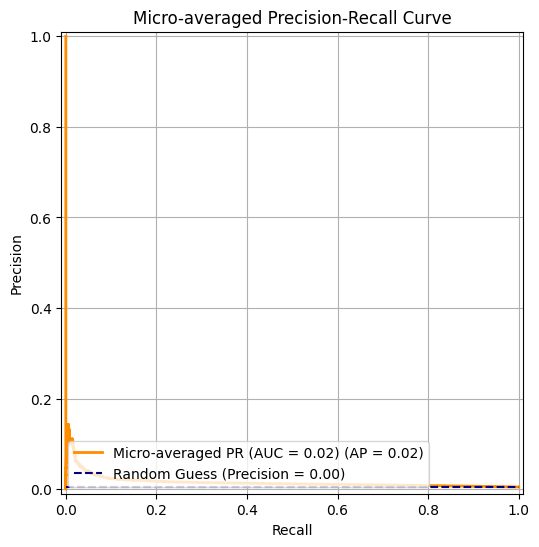


Plotting PR curves for individual peaks...


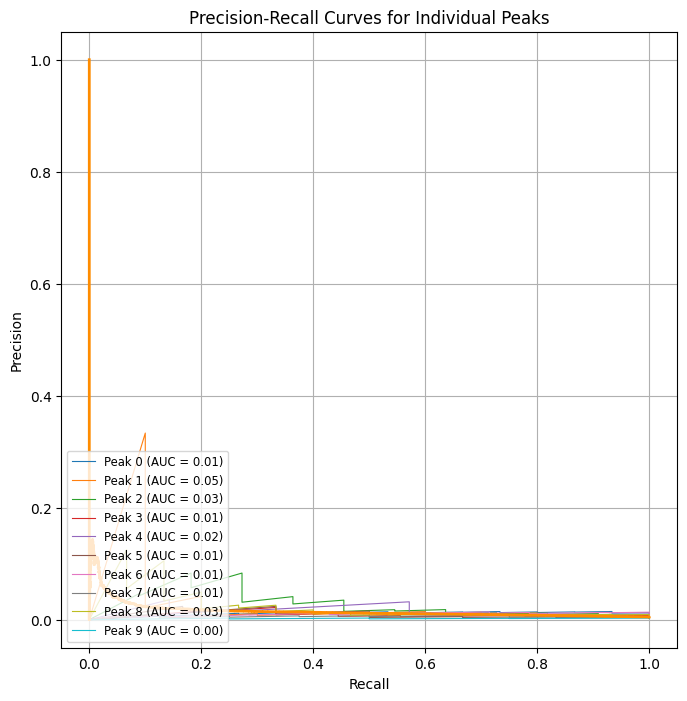

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay



# --- 1. Make predictions (get probabilities) on the test set ---
print("Making predictions on X_test to get probabilities...")
y_pred_probabilities = model.predict(X_test)

# --- 2. Calculate Micro-averaged PR AUC and Plot ---
# Flatten the true and predicted labels for micro-averaging
y_test_flat = y_test.flatten()
y_pred_proba_flat = y_pred_probabilities.flatten()

# Calculate Precision-Recall curve and Average Precision (PR AUC) for micro-average
precision_micro, recall_micro, _ = precision_recall_curve(y_test_flat, y_pred_proba_flat)
pr_auc_micro = average_precision_score(y_test_flat, y_pred_proba_flat, average="micro")

print(f"\nMicro-averaged PR AUC: {pr_auc_micro:.4f}")

# Plotting the Micro-averaged PR curve
plt.figure(figsize=(8, 6))
disp = PrecisionRecallDisplay(precision=precision_micro, recall=recall_micro,
                              average_precision=pr_auc_micro, estimator_name='Micro-averaged')
disp.plot(ax=plt.gca(), name=f"Micro-averaged PR (AUC = {pr_auc_micro:.2f})", color='darkorange', lw=2)
plt.plot([0, 1], [np.sum(y_test_flat == 1) / len(y_test_flat), np.sum(y_test_flat == 1) / len(y_test_flat)],
         linestyle='--', color='navy', label=f'Random Guess (Precision = {np.sum(y_test_flat == 1) / len(y_test_flat):.2f})')

plt.title('Micro-averaged Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()


# --- 3. Plot PR Curves for Individual Peaks (Example for a few peaks) ---
print("\nPlotting PR curves for individual peaks...")
# You might want to select specific peaks, or a random subset, if you have many (e.g., 500)
# Here, we'll plot for the first 10 peaks as an example.
num_peaks_to_plot = min(10, y_test.shape[1])

plt.figure(figsize=(10, 8))
lines = []
labels = []

for i in range(num_peaks_to_plot):
    y_true_peak = y_test[:, i]
    y_scores_peak = y_pred_probabilities[:, i]

    # Only plot if there are actual positive samples for this peak
    if np.sum(y_true_peak == 1) > 0:
        precision_peak, recall_peak, _ = precision_recall_curve(y_true_peak, y_scores_peak)
        pr_auc_peak = average_precision_score(y_true_peak, y_scores_peak)

        line, = plt.plot(recall_peak, precision_peak, lw=0.8,
                         label=f'Peak {i} (AUC = {pr_auc_peak:.2f})')
        lines.append(line)
        labels.append(f'Peak {i} (AUC = {pr_auc_peak:.2f})')
    else:
        print(f"Skipping Peak {i}: No positive samples in y_test.")


# Plot the Micro-averaged PR curve again for comparison
pr_auc_micro_display = PrecisionRecallDisplay(precision=precision_micro, recall=recall_micro,
                                               average_precision=pr_auc_micro, estimator_name='Micro-averaged')
pr_auc_micro_display.plot(ax=plt.gca(), name=f"Micro-averaged PR (AUC = {pr_auc_micro:.2f})",
                           color='darkorange', lw=2, linestyle='-')

# Add random guess baseline for individual peaks (depends on the base rate of 1s in each peak)
# For simplicity, we can plot the average baseline or omit for individual peaks.
# For multi-label PR curves, the baseline varies per label based on its prevalence.
# If you want a global baseline, use the micro-averaged one.

plt.title('Precision-Recall Curves for Individual Peaks')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend(lines, labels, loc='lower left', fontsize='small')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.show()